In [577]:
import numpy as np
import timeit
import scipy.linalg
import warnings
import math
import matplotlib.pyplot as plt
import pandas as pd
import cmath
from random import random

warnings.filterwarnings('ignore')

In [578]:
#obliczenie jednostki maszynowej
epsilon = 0.5
while True:
    if 1 + epsilon != 1:
        epsilon = epsilon/2
    else:
        print("Jednostka maszynowa tej jednostki to : {}".format(epsilon))
        break

Jednostka maszynowa tej jednostki to : 1.1102230246251565e-16


# Definicje funkcji

### rootsearch

In [579]:
def rootsearch(f,a,b,dx):
    x1 = a; f1 = f(a)
    x2 = a + dx; f2 = f(x2)
    while np.sign(f1) == np.sign(f2):
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2)
    else:
        return x1,x2

### bisekcja

In [580]:
def bisection(f,x1,x2,switch=1,epsilon= 1.0e-9):
    f1 = f(x1)
    if f1 == 0.0: return x1
    f2 = f(x2)
    if f2 == 0.0: return x2
    if np.sign(f1) == np.sign(f2):
        raise ValueError("Znaki są równe")
    n = int(math.ceil(math.log(abs(x2 - x1)/epsilon)/math.log(2.0)))
    add_num_operations = 0
    product_num_operations = 0
    for i in range(n):
        x3 = 0.5*(x1 + x2); f3 = f(x3)
        add_num_operations += 1
        product_num_operations += 1
        if (switch == 1) and (abs(f3) > abs(f1)) and (abs(f3) > abs(f2)):
            return None
        if f3 == 0.0: return x3
        if np.sign(f2)!= np.sign(f3): x1 = x3; f1 = f3
        else: x2 = x3; f2 = f3

    return (x1 + x2)/2.0, n, add_num_operations, product_num_operations

### metoda Newtona

In [581]:
def newton(f,df,x0,epsilon= 1e-16,max_iter=1000):
    xn = x0
    add_num_operations = 0
    product_num_operations = 0
    for n in range(0,max_iter):
        fxn = f(xn)
        if abs(fxn) < epsilon:
            return xn, n, add_num_operations, product_num_operations
        Dfxn = df(xn)
        if Dfxn == 0:
            raise ZeroDivisionError("Dzielenie przez zero w metodzie siecznych")
        xn = xn - fxn/Dfxn
        add_num_operations += 1
        product_num_operations += 1
    print("Exceeded maximum iterations. No solution found.")
    return None

### metoda siecznych

In [582]:
def secant(f, x0, x1, epsilon=1e-16, max_iter=1000):
    add_num_operations = 0
    product_num_operations = 0
    for iteration in range(max_iter):
        f_x0 = f(x0)
        f_x1 = f(x1)
        if abs(f_x1 - f_x0) < 1e-12:
            raise ZeroDivisionError("Dzielenie przez zero w metodzie siecznych")

        x2 = x1 - f_x1 * (x1 - x0) / (f_x1 - f_x0)
        add_num_operations += 3
        product_num_operations += 2

        if abs(x2 - x1) < epsilon:
            return x2, iteration + 1, add_num_operations, product_num_operations 

        x0, x1 = x1, x2

    raise RuntimeError("Metoda siecznych nie znalazła rozwiązania po maksymalnej liczbie iteracji")

### metoda Brenta

In [583]:
def brent(f, a, b, epsilon=1e-16, max_iter=1000):
    fa, fb = f(a), f(b)
    if fa * fb > 0:
        raise ValueError("Funkcja musi zmieniać znak w przedziale [a, b]")

    add_num_operations = 0
    product_num_operations = 0
    c, fc = a, fa
    for iteration in range(max_iter):
        if fb != fc and fa != fc:
            s = a * fb * fc / ((fa - fb) * (fa - fc)) + \
                b * fa * fc / ((fb - fa) * (fb - fc)) + \
                c * fa * fb / ((fc - fa) * (fc - fb))
            add_num_operations += 8
            product_num_operations += 12
        else:
            s = b - fb * (b - a) / (fb - fa)
            add_num_operations += 3
            product_num_operations += 2

        if not (a < s < b):
            s = (a + b) / 2
            add_num_operations += 1
            product_num_operations += 1

        fs = f(s)
        d, c, fc = b - a, b, fb
        if abs(fs) < epsilon:
            return s, iteration + 1, add_num_operations, product_num_operations

        product_num_operations += 1
        if fa * fs < 0:
            b, fb = s, fs
        else:
            a, fa = s, fs

    raise RuntimeError("Metoda Brenta nie znalazła rozwiązania po maksymalnej liczbie iteracji")

### metoda Laguerra

In [584]:
def evalPoly(a,x):
    n = len(a) - 1
    p = a[n]
    dp = 0.0 + 0.0j
    ddp = 0.0 + 0.0j
    for i in range(1,n+1):
        ddp = ddp*x + 2.0*dp
        dp = dp*x + p
        p = p*x + a[n-i]
    return p,dp,ddp

def polyRoots(a,tol=1.0e-12):

    def laguerre(a,tol):
        x = random() # Starting value (random number)
        n = len(a) - 1
    
        for i in range(30):
            p,dp,ddp = evalPoly(a,x)
            if abs(p) < tol: 
                return x
            g = dp/p
            h = g*g - ddp/p
            f = cmath.sqrt((n - 1)*(n*h - g*g))
            if abs(g + f) > abs(g - f): 
                dx = n/(g + f)
            else: 
                dx = n/(g - f)
            x = x - dx
            if abs(dx) < tol: 
                return x
        print('Too many iterations')
        
        
    def deflPoly(a,root):
        # Deflates a polynomial
        n = len(a)-1
        b = [(0.0 + 0.0j)]*n
        b[n-1] = a[n]
        for i in range(n-2,-1,-1):
            b[i] = a[i+1] + root*b[i+1]
        return b


    n = len(a) - 1
    roots = np.zeros((n),dtype=complex)
    for i in range(n):
        x = laguerre(a,tol)
        if abs(x.imag) < tol: x = x.real
        roots[i] = x
        a = deflPoly(a,x)
    return roots

# Zadanie 1


Definiujemy funkcję podaną w zadaniu oraz jej pochodną

In [585]:
def f(x):
    return np.tan(np.pi - x) - x

def df(x):
    return -1 * (1/np.cos(x))**2 - 1

Ustawiamy wejściowe parametry

In [586]:
a, b = 2.0, 3.0 
x0 = 2.5 
x1 = 2.7 

Następnie zgodnie z poleceniem zadania sprawdzę implementację każdej z zdefiniowanych metod rozwiązania

In [587]:
results = []

root_bis, iterations_bis, additions_bis, product_bis = bisection(f, a, b)
results.append(["Bisekcja", root_bis, f(root_bis), iterations_bis, additions_bis, product_bis])

root_newton, iterations_newton, additions_newton, product_newton = newton(f, df, x0)
results.append(["Newtona", root_newton, f(root_newton), iterations_newton, additions_newton, product_newton])

root_s, iterations_s, additions_s, products_s = secant(f, x0, x1)
results.append(["Siecznych", root_s, f(root_s), iterations_s, additions_s, products_s])

root_brent, iterations_brent, additions_brent, products_brent = brent(f, a, b)
results.append(["Brenta", root_brent, f(root_brent), iterations_brent, additions_brent, products_brent])

table = pd.DataFrame(results, columns=["Metoda", "x", "f(x)", "Liczba iteracji", "Liczba dodawań", "Liczba mnożeń"])

print("\nPodsumowanie wyników")
table



Podsumowanie wyników


,Metoda,x,f(x),Liczba iteracji,Liczba dodawań,Liczba mnożeń
0,Bisekcja,2.028758,2.676717e-10,30,30,30
1,Newtona,2.028758,0.000000e+00,7,7,7
2,Siecznych,2.028758,0.000000e+00,11,33,22
3,Brenta,2.028758,0.000000e+00,7,36,50


# Zadanie 2

Rozpoczynamy od zdefiniowania funkcji i pochodnych 

In [588]:
def f(x):
    return np.cosh(x) * np.cos(x) - 1
def df(x):
    return (np.cos(x) * np.sinh(x)) - (np.sin(x) * np.cosh(x))
def ddf(x):
    return -2 * np.sin(x) * np.sinh(x)

Definiujemy przedział

In [589]:
x_range = np.linspace(4,8,1000)

Wyrysujemy wykres funkcji

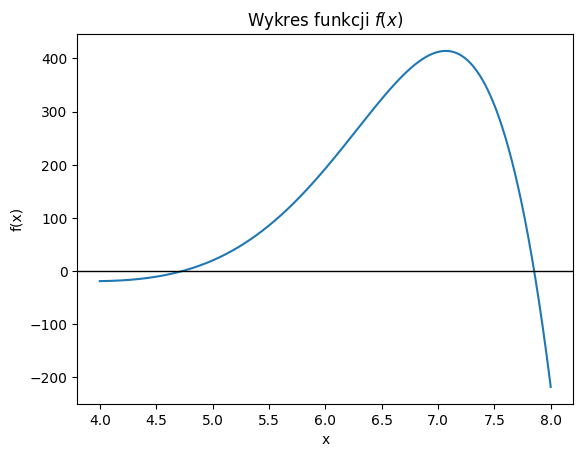

In [590]:
plt.plot(x_range,f(x_range))
plt.axhline(0, color='black', linewidth=1, linestyle='-')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Wykres funkcji $f(x)$')
plt.show()

Zawężamy rozpatrywany przedział do [4,5]

In [591]:
x_range = np.linspace(4,5,1000)
a=4
b=5

Sprawdzamy warunki do metody Newtona: funkcja musi być ciągła, f(a)*f(b)<0 , f'(x) oraz f''(x) mają stały znak na rozpatrywanym przedziale


In [592]:
print(f(a)-f(b))

-38.900408371975246


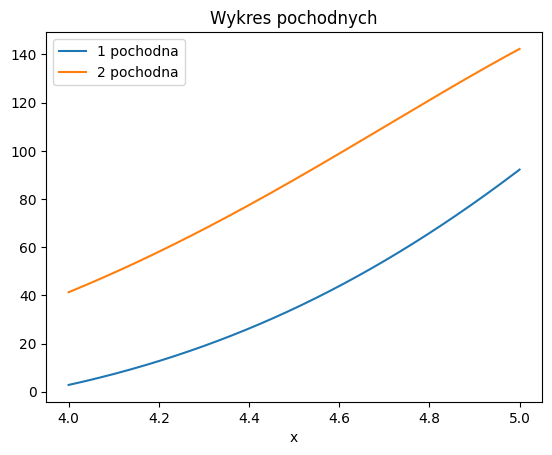

In [593]:
plt.plot(x_range,df(x_range), label='1 pochodna')
plt.plot(x_range,ddf(x_range), label='2 pochodna')
plt.xlabel('x')
plt.title('Wykres pochodnych')
plt.legend()
plt.show()

Teraz przystąpujemy do zastosowania metody

In [594]:
x0 = 4
root_newton = newton(f, df, x0, epsilon)

Exceeded maximum iterations. No solution found.


Tak jak zakładano, zaczynając od 4 metoda nie doprowadzi do pierwiastka

# Zadanie 3

Definiujemy funkcję obliczania prędkości rakiety

In [595]:
def velocity(t):
    g = 9.81  # przyspieszenie ziemskie [m/s^2]

    # Dziedzina logarytmu musi być dodatnia
    if M_0 - m_dot * t <= 0:
        return np.nan

    return u * np.log(M_0 / (M_0 - m_dot * t)) - g * t - 335 

Argumenty funkcji zdefiniowane są potem, aby móc ją wsadzić do bisekcji

In [596]:
u = 2510  # prędkość spalin względem rakiety [m/s]
M_0 = 2.8e6  # masa rakiety w momencie oderwania od Ziemi [kg]
m_dot = 13.3e3  # szybkość zużycia paliwa [kg/s]
t_range = np.linspace(a,b,10**4)

t_max = M_0 / m_dot  # Maksymalny czas, zanim paliwo się skończy
a, b = 0, t_max - 1e-6  # Przedział dla metod


I wyszukuję rozwiązań

In [597]:
root_bisection, _ , __ , ___  = bisection(velocity, a, b)
print(f"Czas osiągnięcia prędkości dźwięku (metoda bisekcji): {root_bisection:.6f}")

root_brent, _, __, ___ = brent(velocity, a, b, max_iter=10000)
print(f"Czas osiągnięcia prędkości dźwięku (metoda Brenta): {root_brent:.6f}")


x_root_scipy = scipy.optimize.fsolve(velocity, 0)
print('Rozwiązanie scipy:', x_root_scipy[0])

Czas osiągnięcia prędkości dźwięku (metoda bisekcji): 70.877972
Czas osiągnięcia prędkości dźwięku (metoda Brenta): 70.877972
Rozwiązanie scipy: 70.87797226808105


Uzyskane wyniki pokrywają się z rozwiązniem uzyskanym poprzez pakiet scipy

# Zadanie 4

Definiujemy funkcję


In [598]:
def G(T):
    return -8.31441 * T * np.log(np.power(T/4.44418,5/2))

def f(x):
    return G(x) + 10**5

Wyszukujemy przedział na którym występuje miejsce zerowe

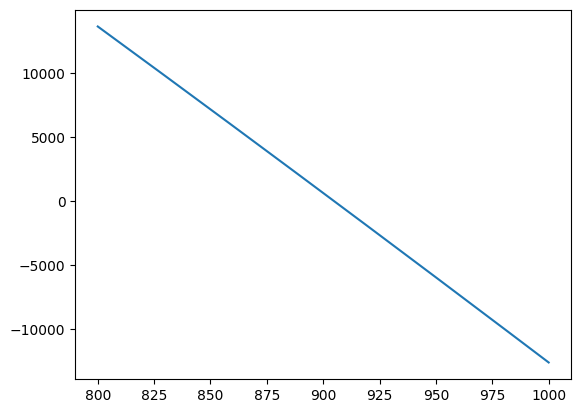

In [599]:
a = 800
b = 1000
x_range = np.linspace(a,b,10**6)

plt.plot(x_range, f(x_range))

Używamy metody bisekcji 

In [600]:
root, _, __, ___ = bisection(f, a, b)
print('Metoda bisekcji (własna):', root)

x_root_scipy = scipy.optimize.newton(f, x0, x1=x1)
print('Metoda bisekcji (scipy):', x_root_scipy)

Metoda bisekcji (własna): 904.942583232696
Metoda bisekcji (scipy): 904.9425832328805


# Zadanie 5

Mamy układ równań

$$
\begin{cases}
\tan(x) - y = 1 \\
\cos(x) - 3\sin(y) = 0
\end{cases}
$$

Przekształcamy je do równania o jednej zmiennej. Z pierwszego równania mamy

$$
y = \tan(x) - 1
$$

Wrzucamy to do pierwszego równania

$$
\cos(x) - 3\sin(\tan(x) - 1) = 0
$$

Pochodna tej funkcji wynosi

$$
f'(x) = -\sin(x) - 3\cos(\tan(x) - 1) \cdot (\frac{1}{\cos^2(x)})
$$

In [601]:
def f(x):
    if np.abs(np.cos(x)) < 1e-16: 
        return np.nan
    return np.cos(x) - 3 * np.sin(np.tan(x) - 1)

def df(x):
    if np.abs(np.cos(x)) < 1e-16: 
        return np.nan
    return -np.sin(x) - 3 * np.cos(np.tan(x) - 1) * (1 / np.cos(x)**2)

Definiujemy podstawowe własności i zakres w celu wykorzystania razem z metodą Newtona

In [602]:
x0_values = np.linspace(0.1, 1.5, 100)

epsilon = 1e-6
maxit = 100

solutions = []
for x0 in x0_values:
    try:
        root, _, __, ___ = newton(f, df, x0, epsilon, maxit)
        # Sprawdzamy, czy rozwiązanie jest w zadanym przedziale
        if root is not None and 0 < root < 1.5 and all(abs(root - sol) > epsilon for sol in solutions):
            solutions.append(root)
    except RuntimeError:
        pass

print("Znalezione rozwiązania:")
for sol in solutions:
    print(f"x = {sol:.4f}")

Znalezione rozwiązania:
x = 1.4973
x = 1.4749
x = 1.4352
x = 0.8816
x = 1.3294


Wyniki zaprezentujemy na wykresie

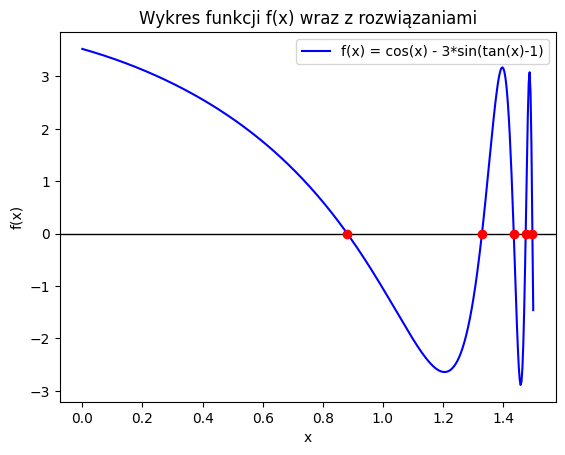

In [603]:
x_vals = np.linspace(0, 1.5, 500)
y_vals = [f(x) for x in x_vals]

plt.plot(x_vals, y_vals, label="f(x) = cos(x) - 3*sin(tan(x)-1)", color='b')
plt.axhline(0, color='black', linewidth=1)
plt.title("Wykres funkcji f(x) wraz z rozwiązaniami")
plt.xlabel("x")
plt.ylabel("f(x)")

for sol in solutions:
    plt.plot(sol, f(sol), 'ro')

plt.legend()
plt.show()

Zgadza się.

# Zadanie 6

In [604]:
def w(x):
    return x**4 + (5+1j)*x**3 - (8-5j)*x**2 + (30-14j)*x - 84 

Funkcja przyjmuje wartości zespolone, więc skorzystamy z metody Laguerre'a

In [606]:
polynomials = [-84, 30-14j, -8+5j, 5+1j, 1]
roots = polyRoots(polynomials)
print("Znaleziono pierwiastki: {}:".format(np.round(roots)))

Znaleziono pierwiastki: [ 2.+0.j -0.+2.j  0.-3.j -7.+0.j]:
